In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import pickle

from collections import defaultdict
import networkx as nx
from scipy.linalg import cholesky
from utils import *
from plot import *

with open('data/data.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
env = data_new['env']
obj = data_new['obj']

# Code tests

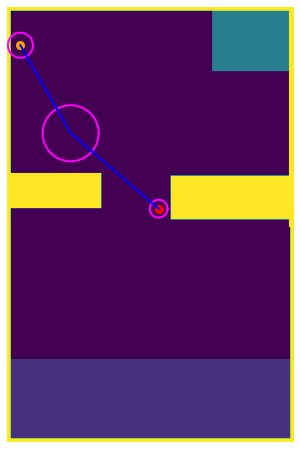

Iteration: 0 vertices 1


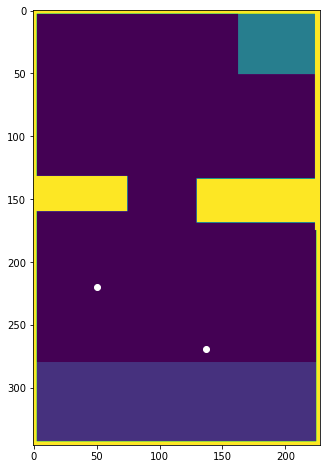

In [2]:
# testing params are in the  file
from code_tests import *

test_path_vizualization(env)
sampling_iterations = 1
cov_matrix_diag = 1
step = 100
check_sampling_and_steering(env,
                            sampling_iterations,
                            cov_matrix_diag,
                            step)

# GRAPH RRBT

In [139]:
from Dubins.dubins import Dubins
from propagate import DynamicModel,BeliefNode

class GraphRRTBNX:
    
    def __init__(self, start, end, step=75,k = 650,ellipse_number_of_points = 30):
        self.start = start
        self.end = end
        self.step = step
#         self.weight = weight
        self.ellipse_number_of_points = ellipse_number_of_points
        self.G = nx.DiGraph()
        root_belief = [BeliefNode(np.eye(3)*k,np.zeros((3,3)), 0)]
        
        self.G.add_node(0, val = self.start, belief_nodes = root_belief )
    
    def num_of_vertices(self):
        return len(self.G.nodes)
    
    def find_nearest(self, random_point):
        min_distance = 1e7
        min_index = None
        
        for index, vert in enumerate(self.G.nodes):
            vert = np.array(self.G.nodes[vert]['val'])
            distance = get_distance(random_point, vert)
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
    def get_neighbors(self,vertex_id):
        return list(self.G.neighbors(vertex_id))

    def near(self, v_new, radius = None, d = 3):
        n = len(self.G.nodes)

        near_set = []
        if (radius is None):
            radius = calc_radius(n, d)
        
        for vertex in self.G.nodes:
            vertex_coords = np.array(self.G.nodes[vertex]['val'])[:2]
            distance = np.linalg.norm(vertex_coords - v_new[:2])
            if distance <= radius + 1e-3:
                near_set.append(vertex)

        return near_set

    def create_plan(self,radius, test_point = None):
        plan = []
        belief_nodes = []
        
        goal_vertices_indices = self.near(self.end[:2],radius)
             
        best_node = self.G.nodes[goal_vertices_indices[0]]['belief_nodes'][0]
        
        for vertex in goal_vertices_indices:
            for vertex_node in self.G.nodes[vertex]['belief_nodes']:
                if(self.is_candidate_better(best_node,vertex_node, 1e-3)):
                    best_node = vertex_node
        
        plan.append(self.end)
        belief_nodes.append(best_node)
        current_node = best_node
        
        vertex_id = self.get_vertex_for_belief_node(best_node)
        plan.append(self.G.nodes[vertex_id]['val'])
        belief_nodes.append(best_node)
        
        while(current_node != None):
            current_node = current_node.parent
            if (current_node == None):
                break
            vertex_id = self.get_vertex_for_belief_node(current_node)
            plan.append(self.G.nodes[vertex_id]['val'])
            belief_nodes.append(current_node)
        
        plan.reverse()
        belief_nodes.reverse()
        
        return plan,belief_nodes
    
    def propagate(self,env,path_states, start_belief, dt):
        if (len(path_states) < 2):
            return None
        Sigma = start_belief.Sigma.copy()

        Lambda = start_belief.Lambda.copy()
        observable_check_const = 1
        
        check_delta = int(len(path_states) / 3)
        if (check_delta < 1e-9): 
            check_delta = 1
        
        for it in range(len(path_states)):
            env_indexes = tuple(path_states[it].astype(int))

            is_observable = is_state_observable(env, env_indexes, observable_check_const)
            if (is_observable):
                Sigma *= 0.965
            else: 
                Sigma += np.eye(3) * 0.15
                       
        cov_matrix = Sigma + np.eye(3) #+ Lambda 
        cost = start_belief.cost + path_length(path_states)
        if (not (is_state_collision_free(env,tuple(path_states[-1].astype(int)),
                                         cov_matrix[:2,:2],
                                         self.ellipse_number_of_points))):
#             print("last state not passed",path_states[-1])
            return None
#         else: 
#             print("last state has passed",path_states[-1],"with Sigma", np.linalg.norm(cov_matrix[:2,:2]))
#             print("actual Sigma",np.linalg.norm(Sigma[:2,:2]) )
        
        return BeliefNode(Sigma, Lambda, cost, parent = start_belief)    
    
    def is_candidate_better(self,current_node,candidate_node, eps = 1e-3):
        
        is_sigma_better =  np.linalg.norm(current_node.Sigma + np.eye(3)*eps) > np.linalg.norm(candidate_node.Sigma)
#         is_lambda_better = np.linalg.norm(current_node.Lambda+np.eye(3)*eps) > np.linalg.norm(candidate_node.Lambda)
        is_cost_better = current_node.cost > candidate_node.cost
        if (is_sigma_better and is_cost_better):
            return True
        else: 
            return False
    
    def get_vertex_for_belief_node(self,belief_node):
        for vertex_id,data in self.G.nodes.data():
            vertex_nodes = data['belief_nodes']
            for node in vertex_nodes:
                if (belief_node == node):
                    return vertex_id
        return None

    def rttb(self, n_iter = 5):
        local_planner = Dubins(radius= 5, point_separation= 1)
        dt = 1e-5
        new_vertex_index = -1
        for i in range(n_iter):
            if not i % 100:
                print('Iteration:',i, "vertices", self.num_of_vertices())
            
            belief_nodes_to_explore = []
            random_state = self.sample_state()

            nearest_index = self.find_nearest(random_state)
            nearest_state = self.G.nodes[nearest_index]['val']    
            candidate_state = steer_func(nearest_state,random_state,self.step)
            
            if (not is_state_collision_free(env,candidate_state[:2],np.eye(2),3)):
                continue
                
#             path = connect(nearest_state, candidate_state, dt, plot = False)

            path = local_planner.dubins_path(nearest_state, candidate_state)
        
            d_start = nearest_state[:2] - path[0]
            d_end = candidate_state[:2] - path[-1]
            if(np.linalg.norm(d_start[:2]) > 1 or np.linalg.norm(d_end[:2]) > 1):
                print("real start and end states",nearest_state,candidate_state )
                print("start and end state inside dubins", path[0][0],path[0][-1])
                continue
                
            propagated = False

            for belief_node in self.G.nodes[nearest_index]['belief_nodes']:
#                 print("trying belief_node with sigma", np.linalg.norm(belief_node.Sigma[:2,:2]))
                candidate = self.propagate(env,path, belief_node, dt)
                if(candidate is not None):
                    propagated = True
                    new_vertex_index = self.num_of_vertices()
#                     print("adding state",candidate_state,"with sigma", np.linalg.norm(candidate.Sigma[:2,:2]))
                    self.G.add_node(new_vertex_index, val = candidate_state,belief_nodes = [candidate])
                    
                    self.G.add_edge(nearest_index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[nearest_index]['belief_nodes'] 
                    break
            if (not propagated):
                continue
            
            near_vertices_indices = self.near(candidate_state)
            try:
                near_vertices_indices.remove(nearest_index)
            except Exception as e:
                pass

            for index in near_vertices_indices:
                if index != new_vertex_index:
                    self.G.add_edge(index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[index]['belief_nodes']
            
            while(belief_nodes_to_explore):
                current_node = belief_nodes_to_explore.pop()
                vertex_id = self.get_vertex_for_belief_node(current_node)
                for neigh_vertex in self.get_neighbors(vertex_id):
                    path_from_node_to_neigh = local_planner.dubins_path(self.G.nodes[vertex_id]['val'], 
                                                                        self.G.nodes[neigh_vertex]['val'])
#                     path_from_node_to_neigh = connect(self.G.nodes[vertex_id]['val'],
#                                                       self.G.nodes[neigh_vertex]['val'],
#                                                       dt, plot = False)
                    candidate = self.propagate(env,path_from_node_to_neigh, current_node, dt)
                    if(candidate is not None):
                        vertex_node = self.G.nodes[neigh_vertex]['belief_nodes'][0]
                        if(self.is_candidate_better(vertex_node,candidate,0)):
                            self.G.nodes[neigh_vertex]['belief_nodes'].insert(0,candidate)
#                             print("adding node with norm", np.linalg.norm(candidate.Sigma[:2,:2]),
#                                   len(self.G.nodes[neigh_vertex]['belief_nodes']))
#                             print("all nodes",self.G.nodes[neigh_vertex]['belief_nodes'])
                            belief_nodes_to_explore +=  [candidate]
#                             print("candidate",candidate)
#                             print("candidate.parent",candidate.parent)
                            if (len(self.G.nodes[neigh_vertex]['belief_nodes']) > 7):
                                print("reached 7 belief nodes in state",(self.G.nodes[neigh_vertex]['val'] ))
                                self.G.nodes[neigh_vertex]['belief_nodes'].pop()
            
    def sample_state(self):
        global x_rng, y_rng,theta_rng 

        key = np.random.rand(1)
        if (key < 0.95):
            x = x_rng.integers(low = 50, high = env.shape[0] - 20) #env.shape[0] - 2
            y = y_rng.integers(low = 2, high = env.shape[1] - 2) #env.shape[1] - 2
            theta =  2*np.pi * theta_rng.random() - np.pi
            return np.array([x,y,theta])
        else:
            return self.end

In [140]:
#uniform generators initialization
x_rng = np.random.default_rng(seed = 3)
y_rng = np.random.default_rng(seed = 6)
theta_rng = np.random.default_rng(seed = 10)

def calc_radius(n: int, d: int = 3) -> float:
    radius = 10
    #     radius = (np.log(n) / n) ** (1 / d) * 15
    return radius

def is_state_observable(env,state, obs_val):
#     if(env[state] == obs_val):
    if(state[0] > 240): 
        return True
    else: 
        return False
initial_point = np.array([200.0, 30.0, np.pi/2])
finish_point = np.array([120.0, 110.0, np.pi/2])
# finish_point = np.array([180.0, 120.0, np.pi/2])
# finish_point = np.array([250.0, 170.0, np.pi/2])
step = 3
initial_covariance_matrix = 750 # in order to make pass impossible
ellipse_number_of_points = 30

g = GraphRRTBNX(initial_point, finish_point,  step, initial_covariance_matrix,ellipse_number_of_points)
g.rttb(10)

# goal_radius = 20

# try:
#     plan,nodes = g.create_plan(goal_radius)
# except:
#     print("probably not enough iterations")
#     raise
# ellipses_steps = 3
# path_plot(env,plan, nodes,ellipses_steps,ellipse_number_of_points, g.G)
# plot_all_graph_ellipses(env,g.G,ellipse_number_of_points)
# print(g.num_of_vertices())
# for node in g.G.nodes():
#     state = g.G.nodes()[node]['val']
#     b_node = g.G.nodes()[node]['belief_nodes'][0]
#     passed = is_state_collision_free(env,state[:2],b_node.Sigma[:2,:2],10)
#     if (not passed):
#         print("not passed" ,state[:2] ,np.linalg.norm(b_node.Sigma[:2,:2]))

Iteration: 0 vertices 1
candidate (array([[755.4,   0. ,   0. ],
       [  0. , 755.4,   0. ],
       [  0. ,   0. , 755.4]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 34.828964234146426)
candidate.parent (array([[750.,   0.,   0.],
       [  0., 750.,   0.],
       [  0.,   0., 750.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 0)
candidate (array([[760.35,   0.  ,   0.  ],
       [  0.  , 760.35,   0.  ],
       [  0.  ,   0.  , 760.35]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 66.24789409718456)
candidate.parent (array([[755.4,   0. ,   0. ],
       [  0. , 755.4,   0. ],
       [  0. ,   0. , 755.4]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 34.828964234146426)
candidate (array([[755.55,   0.  ,   0.  ],
       [  0.  , 755.55,   0.  ],
       [  0.  ,   0.  , 755.55]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), 35.31474987751255)
candidate.parent (array([[750., 

In [94]:
goal_radius = 10

try:
    plan,nodes = g.create_plan(goal_radius)
except:
    print("probably not enough iterations")
    raise

#we are interested to decrease the SIgma matrix
print(nodes[0].Sigma)
print(nodes[-1].Sigma)

ellipses_steps = 3
path_plot(env,plan, nodes,ellipses_steps,ellipse_number_of_points, g.G)

# # get Dubins path
# dt = 1e-2
# r = 1.5
# states,actions = connect(plan[0], plan[1],r, dt, plot = True)
# print(len(states)) # to 10 points
# # end of Dubins path

# #collision check utils
# plan_step_to_check = -1
# state_to_check = plan[plan_step_to_check][:2]
# cov_matr = nodes[plan_step_to_check].Sigma[:2,:2]

# print(state_to_check, cov_matr)
# print(is_state_collision_free(env,state_to_check, cov_matr))
#end of collision check utils

probably not enough iterations


IndexError: list index out of range

In [ ]:
print(plan)

In [ ]:
def angle_difference(from_ang, to):
    delta_angle =  to - from_ang
    delta_angle = (delta_angle + np.pi) % (2 * np.pi) - np.pi
    return delta_angle
    
def get_distance(state_1,state_2, dis_weight = 1,ang_weight = 20):
    d_xy = np.linalg.norm(state_1[:2] - state_2[:2])
    d_theta = np.abs(angle_difference(state_1[2],state_2[2]))

    return dis_weight * d_xy + ang_weight * d_theta

def steer_func(near_state, final_state,max_xy_step = 20.0, max_angle_step = np.pi/6):
    dir_xy = final_state[:2] - near_state[:2]
    angle = angle_difference(near_state[2],final_state[2])
    new_state = near_state.copy()
    if (np.linalg.norm(dir_xy) < max_xy_step):
        new_state[:2] = final_state[:2]
    else: 
        new_state[:2] += dir_xy * (max_xy_step / np.linalg.norm(dir_xy))
    
    if (np.abs(angle) < max_angle_step):
        new_state[2] += angle
    else: 
        new_state[2] += np.copysign(max_angle_step,angle)
    return new_state

def is_state_collision_free(env,mu, Sigma, nSigma = 1,n_points = 10):
    """
    Checks collison of the ellipse with given the Gaussian distribution parameters.
    """
    x_y_new = get_cov_ellipse(mu[:2],Sigma[:2,:2],n_points = n_points)
    for xy in x_y_new:
        check_state = tuple(xy.astype(int))
        if(check_state[0] < 0): return False
        if(check_state[0] > env.shape[0]-1): return False
        if(check_state[1] < 0): return False
        if(check_state[1] > env.shape[1]-1): return False
        if (is_point_in_collision(env,check_state,7)):
            return False
    
    return True
    

news = steer_func(np.array([1,1, 2 * np.pi]),np.array([20,200, 3.0 * np.pi -1e-3]))
print(news)
print(is_state_collision_free(env,(120,200), np.eye(2)*1e3))
print(is_point_in_collision(env,(120,200),7))